## Importing things 

In [140]:
import sys
sys.path.append('../misc')

from MoviaBusDataset import MoviaBusDataset
from BaseNetwork import BaseNetwork
import numpy as np
from FNN import FNN
from Seq2Seq import Seq2Seq

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [153]:
previous_timesteps = 6
prediction_steps = 6
batch_size = 25

train = MoviaBusDataset('../data/train', interpolation=True, 
                        prev_timesteps=previous_timesteps, 
                        max_future_time_steps=prediction_steps, 
                        timeofday = True)
train2 = MoviaBusDataset('../data/train', interpolation=True, 
                        prev_timesteps=previous_timesteps, 
                        max_future_time_steps=prediction_steps, 
                        )

validation = MoviaBusDataset('../data/validation', interpolation=True, 
                       prev_timesteps=previous_timesteps, 
                       max_future_time_steps=prediction_steps, 
                       timeofday = True)
validation2 = MoviaBusDataset('../data/validation', interpolation=True, 
                       prev_timesteps=previous_timesteps, 
                       max_future_time_steps=prediction_steps)


test = MoviaBusDataset('../data/test', interpolation=True, 
                       prev_timesteps=previous_timesteps, 
                       max_future_time_steps=prediction_steps, 
                       timeofday = True)
test2 = MoviaBusDataset('../data/test', interpolation=True, 
                       prev_timesteps=previous_timesteps, 
                       max_future_time_steps=prediction_steps)

train.remove_trend()
validation.remove_trend(train._historical_average)
test.remove_trend(train._historical_average)

train2.remove_trend()
validation2.remove_trend(train2._historical_average)
test2.remove_trend(train2._historical_average)

train2.normalize(individual_roads=False)
validation2.normalize(train2.mean, train2.std)
test2.normalize(train2.mean, train2.std)

## FNN

In [162]:
net_FNN = FNN(num_hidden=20)
net_FNN.load('FNN.pt')

validation_scores=[net_FNN.get_MAE_score(validation,timestep=i) for i in range(1,prediction_steps+1)]
print('Validation score:\n',validation_scores)
print('\nMean validation score for all timesteps:\n',sum(validation_scores)/len(validation_scores))

test_scores=[net_FNN.get_MAE_score(test,timestep=i) for i in range(1,prediction_steps+1)]
print('\nTest score:\n',test_scores)
print('\nMean test score for all timesteps:\n',sum(test_scores)/len(test_scores))

Validation score:
 [1.4687063694000244, 1.5087370872497559, 1.5234266519546509, 1.5314874649047852, 1.54054856300354, 1.55182683467865]

Mean validation score for all timesteps:
 1.5207888285319011

Test score:
 [1.4667346477508545, 1.5024441480636597, 1.5155147314071655, 1.5243514776229858, 1.5322452783584595, 1.5382344722747803]

Mean test score for all timesteps:
 1.5132541259129841


<Figure size 640x480 with 1 Axes>

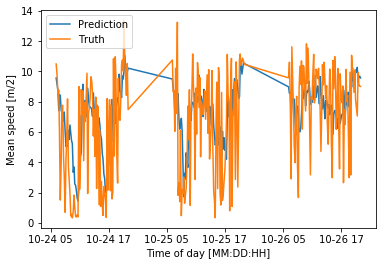

In [163]:
net_FNN.visualize_road(test, timesteps=1, road=17)

## Seq2Seq

In [159]:
net_s2s = Seq2Seq()
net_s2s._BaseNetwork__target_to_net = True
net_s2s.load('Sequence2Sequence.pt')

validation_scores=[net_s2s.get_MAE_score(validation2,timestep=i) for i in range(1,prediction_steps+1)]
print('Validation score:\n',validation_scores)
print('\nMean validation score for all timesteps:\n',sum(validation_scores)/len(validation_scores))

test_scores=[net_s2s.get_MAE_score(test2,timestep=i) for i in range(1,prediction_steps+1)]
print('\nTest score:\n',test_scores)
print('\nMean test score for all timesteps:\n',sum(test_scores)/len(test_scores))

Validation score:
 [1.5216959714889526, 1.5257223844528198, 1.5299543142318726, 1.534583330154419, 1.5416487455368042, 1.5448428392410278]

Mean validation score for all timesteps:
 1.5330745975176494

Test score:
 [1.5241366624832153, 1.5242396593093872, 1.5267146825790405, 1.5291073322296143, 1.5355256795883179, 1.540012240409851]

Mean test score for all timesteps:
 1.529956042766571


In [ ]:
time,out_s2s,tar = net_s2s.visualize_road(test2, timesteps=6, road=16)
_,out_fnn,_ = net_FNN.visualize_road(test, timesteps=6, road=16)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.plot(time,out_s2s, label='Truth_s2s')
plt.plot(time,tar, label='Prediction')
plt.plot(time,out_fnn, label='Truth_fnn')
plt.legend()
plt.xlabel('Time of day [MM:DD:HH]')
plt.ylabel('Mean speed [m/2]')
plt.show()

## DCRNN 

In [2]:
import numpy as np
out_dcrnn = None
with np.load('../dcrnn.npz') as data:
    # also contains groundtruth
    out_dcrnn = np.abs(data['predictions'] - data['groundtruth'])

### Stats

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
stats = pd.read_csv('../stats.csv',index_col=['LinkRef'])
stats['dcrnn_t1'],stats['dcrnn_t2'],stats['dcrnn_t3'],stats['dcrnn_t4'],stats['dcrnn_t5'],stats['dcrnn_t6'] = out_dcrnn.mean(axis=1)
data_norm = (stats.sub(stats.mean(axis=0,numeric_only=True),axis=1))/stats.std(axis=0)
#plt.matshow()
#data_norm
data_norm.corr()


,freq,stops,stds,mean_diff_diff,mean_diff,mean,dcrnn_t1,dcrnn_t2,dcrnn_t3,dcrnn_t4,dcrnn_t5,dcrnn_t6
freq,1.000000,0.203034,-0.047307,0.029132,-0.000902,-0.429810,-0.023322,-0.040063,-0.042322,-0.041600,-0.040182,-0.037169
stops,0.203034,1.000000,-0.038347,-0.046977,-0.060936,-0.511415,-0.151201,-0.152065,-0.153190,-0.153959,-0.153052,-0.150581
stds,-0.047307,-0.038347,1.000000,0.921349,0.928870,-0.246023,0.891102,0.890613,0.884936,0.881849,0.879358,0.875735
mean_diff_diff,0.029132,-0.046977,0.921349,1.000000,0.997995,-0.249720,0.912779,0.897677,0.887855,0.881956,0.877448,0.872488
mean_diff,-0.000902,-0.060936,0.928870,0.997995,1.000000,-0.227146,0.920307,0.907128,0.897570,0.891641,0.887004,0.882044
mean,-0.429810,-0.511415,-0.246023,-0.249720,-0.227146,1.000000,-0.149132,-0.133469,-0.127970,-0.123911,-0.123934,-0.126178
dcrnn_t1,-0.023322,-0.151201,0.891102,0.912779,0.920307,-0.149132,1.000000,0.997127,0.994188,0.992110,0.989990,0.987509
dcrnn_t2,-0.040063,-0.152065,0.890613,0.897677,0.907128,-0.133469,0.997127,1.000000,0.999059,0.997780,0.996183,0.994478
dcrnn_t3,-0.042322,-0.153190,0.884936,0.887855,0.897570,-0.127970,0.994188,0.999059,1.000000,0.999398,0.998240,0.996970
dcrnn_t4,-0.041600,-0.153959,0.881849,0.881956,0.891641,-0.123911,0.992110,0.997780,0.999398,1.000000,0.999435,0.998580


## Plotting